In [3]:
import pandas as pd
!pip install -q  datasets
from datasets import Dataset
import torch
torch.cuda.empty_cache()

import warnings
warnings.filterwarnings('ignore')

import gc
gc.collect()

0

In [4]:
data = pd.read_csv(r"/kaggle/input/dap-shopee/Generated_Sentences_1.csv")

new_df = data[['text', 'label']]
new_df['label'] = new_df['label'].map({'CG': 1, 'OR': 0})
new_df.sample(5)

,text,label
42667,Chất liệu:da\nMàu sắc:đen\nĐúng với mô tả:đúng...,1
586,Hàng chất lượng. Đẹp,0
10430,Chất lượng thấy phù hợp giá tiền đóng gói sp k...,0
13217,Chất lượng ok giá rẻ nên mua lần sau mình sẽ ...,0
5903,Đồng hồ rẻ mà chất lượng.nên mua nhe mọi người,0


In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(new_df, test_size = 0.2, random_state=42)
train_data, test_data = Dataset.from_pandas(train, preserve_index=False), Dataset.from_pandas(test, preserve_index=False)

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = 'NlpHUST/bert-base-vn'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)

tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/535M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NlpHUST/bert-base-vn and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/371 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/411k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [7]:
from transformers import DataCollatorWithPadding

def preproccess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=128)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
tokenized_train = train_data.map(preproccess_function, batched=True) 
tokenized_test = test_data.map(preproccess_function, batched=True) 

Map:   0%|          | 0/54466 [00:00<?, ? examples/s]

Map:   0%|          | 0/13617 [00:00<?, ? examples/s]

In [8]:
!pip install -q evaluate
!pip install -q seaborn
import numpy as np
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def compute_metrics(eval_pred):
    """Calculate F1 score and plot confusion matrix"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Tính F1-score
    load_f1 = evaluate.load("f1")
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]

    # Vẽ confusion matrix
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(labels), yticklabels=np.unique(labels))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return {"f1": f1}

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.9 MB/s eta 0:00:00


In [9]:
from transformers import TrainingArguments, Trainer

# Training arguments for parameter tuning
training_args = TrainingArguments(
   "new_model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=10,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)

# Trainer which executes the training process
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [10]:
import torch

# Kiểm tra giá trị labels trong train_dataset
print(set(tokenized_train["label"]))

# Kiểm tra xem có giá trị âm hoặc quá lớn không
num_labels = model.config.num_labels
for label in tokenized_train["label"]:
    assert 0 <= label < num_labels, f"Lỗi: label {label} không hợp lệ!"

{0, 1}


In [11]:
trainer.train()

Step,Training Loss
500,0.414700
1000,0.236600
1500,0.218300
2000,0.195000
2500,0.184300
3000,0.164400
3500,0.164000
4000,0.148900
4500,0.136300
5000,0.143400


TrainOutput(global_step=34050, training_loss=0.08718040868924402, metrics={'train_runtime': 5007.4659, 'train_samples_per_second': 108.77, 'train_steps_per_second': 6.8, 'total_flos': 2.246866560018204e+16, 'train_loss': 0.08718040868924402, 'epoch': 10.0})

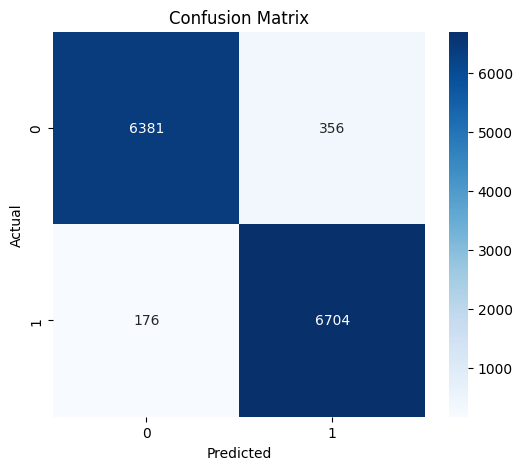

{'eval_loss': 0.2635682225227356,
 'eval_f1': 0.9618364418938308,
 'eval_runtime': 34.8114,
 'eval_samples_per_second': 391.165,
 'eval_steps_per_second': 24.475,
 'epoch': 10.0}

In [12]:
trainer.evaluate()

In [19]:
output_dir = "./model_shopee"
trainer.save_model(output_dir)  # Lưu mô hình
tokenizer.save_pretrained(output_dir)  # Lưu tokenizer

('./model_shopee/tokenizer_config.json',
 './model_shopee/special_tokens_map.json',
 './model_shopee/vocab.txt',
 './model_shopee/added_tokens.json',
 './model_shopee/tokenizer.json')

In [20]:
!zip -r model_shopee.zip model_shopee

  adding: model_shopee/ (stored 0%)
  adding: model_shopee/special_tokens_map.json (deflated 80%)
  adding: model_shopee/tokenizer_config.json (deflated 74%)
  adding: model_shopee/tokenizer.json (deflated 69%)
  adding: model_shopee/vocab.txt (deflated 43%)
  adding: model_shopee/training_args.bin (deflated 52%)
  adding: model_shopee/model.safetensors (deflated 7%)
  adding: model_shopee/config.json (deflated 47%)
